In [67]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pytz
from joblib import dump, load
%matplotlib inline
p = "PuRd"

## 💡TODOs
* We predict weekly returns but trade on a daily basis? -> Trade on a weekly basis
* Hyperparameter Tuning
* Rolling Forecasts
* Predict Prices and calculate R7 from predicted Prices

In [68]:
plt.style.use('default')

# Task 1
Read the historical Bitcoin prices from the provided csv file (btchistorical.csv) and describe the
properties of the dataframe.

In [69]:
# Import the Data
btc = pd.read_csv("btchistorical.csv", parse_dates=["date"])
btc.columns = [c.replace(' ', '_') for c in btc.columns]

In [70]:
btc.shape

(3073, 7)

In [71]:
# Summary statistics
desc = btc.describe()

In [72]:
latex_table = desc.to_latex()
print(latex_table)

\begin{tabular}{lrrrrrr}
\toprule
{} &          open &         close &        volume &          high &           low &    market\_cap \\
\midrule
count &   3073.000000 &   3073.000000 &  3.073000e+03 &   3073.000000 &   3073.000000 &  3.073000e+03 \\
mean  &  11300.065097 &  11308.630346 &  1.395598e+10 &  11595.863515 &  10972.396817 &  2.080593e+11 \\
std   &  16243.433760 &  16242.872749 &  1.954176e+10 &  16665.300947 &  15758.625212 &  3.066943e+11 \\
min   &    176.897003 &    178.102997 &  2.857830e+06 &    211.731003 &    171.509995 &  2.444379e+09 \\
25\%   &    581.650024 &    581.645020 &  5.780140e+07 &    589.151001 &    571.814026 &  7.737830e+09 \\
50\%   &   5271.746394 &   5279.348211 &  4.390020e+09 &   5363.257523 &   5169.283391 &  9.321830e+10 \\
75\%   &  10588.184021 &  10594.493354 &  2.432216e+10 &  10847.256993 &  10291.694493 &  1.893255e+11 \\
max   &  67549.735581 &  67566.830088 &  3.509679e+11 &  68789.625939 &  66382.061008 &  1.274831e+12 \\
\bottomrule

/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_6299/1350195061.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = desc.to_latex()


/var/folders/8h/0y2pf_1n2735m_vsyhnb7lkw0000gn/T/ipykernel_6299/2737591662.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(btc.corr(), cmap=p)


<AxesSubplot: >

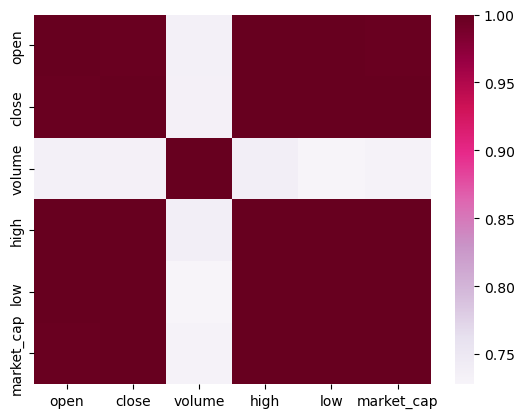

In [73]:
sns.heatmap(btc.corr(), cmap=p)

# Task 2
Construct the following ten predictors/factors based on the provided formulas. Where you need to
calculate a factor that needs price, use the closing price.

In [74]:
btc["MCAP"] = np.log(btc.market_cap)
btc["PRC"] = np.log(btc.close)
btc["MAXDPRC"] = btc.close.rolling(7).apply(lambda x: np.max(x))
# Momentum
for i in range(1,5):
    btc[f"r_{i},0"] = btc.close.rolling(i*7).apply(lambda x: x.iloc[-1]-x.iloc[0])
# TODO Past one-to-four-week return
#btc["r_4,1"] = np.NAN
# ?same value for all datapoints. Should this be done using a rolling mehtod?
btc["PRCVOL"] = list(map(lambda x: np.log(np.average(x.volume)) * x.close.iloc[0], btc.rolling(7)))
btc["STDPRCVOL"] = np.log(np.std(btc.PRCVOL))
btc["DAMIHUD"] = btc.close.rolling(2).apply(lambda x: np.abs((x.iloc[-1]-x.iloc[0])/(x.iloc[0])))

<AxesSubplot: >

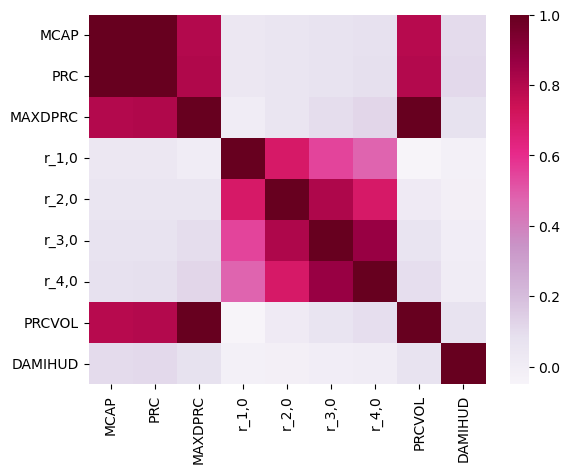

In [75]:
sns.heatmap(btc[['MCAP', 'PRC', 'MAXDPRC', 'r_1,0', 'r_2,0', 'r_3,0', 'r_4,0', 'PRCVOL', 'DAMIHUD']].corr(), cmap=p)

# Task 3
Calculate seven day return based on the closing price using the following formula

In [76]:
# Create 7 day return
btc["R7"] = btc.close.rolling(7).apply(lambda x: (x.iloc[-1]-x.iloc[0])/(x.iloc[0]))
btc.R7= btc.R7.shift(-7)

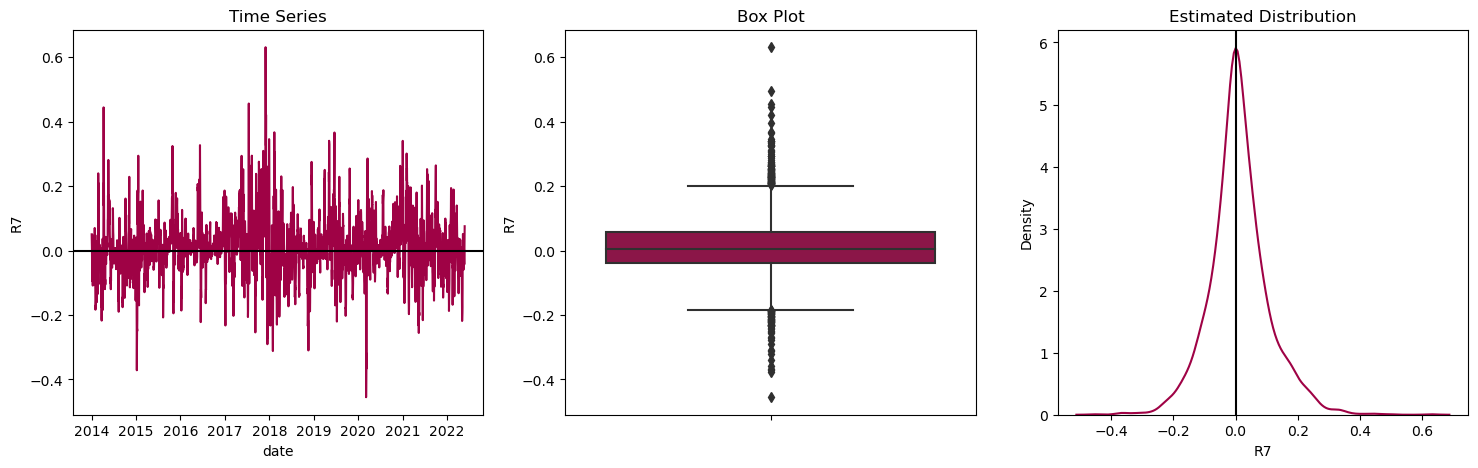

In [77]:
c = sns.color_palette(p)[5]
fig, ax = plt.subplots(figsize=(18, 5), nrows=1, ncols=3)
 # Plot time series as a line graph
sns.lineplot(x=btc.date, y=btc.R7, color=c, ax=ax[0])
ax[0].axhline(color="black")
ax[0].set_title('Time Series')

# Plot time series as a box plot
sns.boxplot(y=btc.R7, color=c, ax=ax[1])
ax[1].set_title('Box Plot')

sns.kdeplot(x=btc.R7, color=c, ax=ax[2])
ax[2].axvline(color="black")
ax[2].set_title('Estimated Distribution')
# Show the plot
plt.show()

In [78]:
# Add 1-14 day lagged prices
for i in range(1,15):
    btc[f"close_lagged_{i}"] = btc.close.shift(periods=i)

# Add number of observation 
btc["t"] = range(len(btc))
# Add Year
btc["year"] = btc.date.apply(lambda x: x.year)
# Add Month
btc["month"] = btc.date.apply(lambda x: x.month)
# Add Day
btc["day"] = btc.date.apply(lambda x: x.day)

In [79]:
# Drop all rows with NaN
btc_cut = btc.dropna()

# Task 4
Divide historical prices and volume (i.e., open, close, high, low, and volume) into training, validation, and testing samples and use linear regression, random forest, and support vector machine to investigate the performance of past prices for return prediction.

## Split Data

In [109]:
def data_split(X, y):
    X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
    X_valid, X_test, y_valid, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [81]:
#X = btc_cut[["open", "close", "high", "low", "volume"]]
X = btc_cut.loc[:, [col not in ['date', 'market_cap', 'MCAP', 'PRC', 'MAXDPRC', 'r_1,0', 'r_2,0', 'r_3,0', 'r_4,0', 'PRCVOL', 'STDPRCVOL', 'DAMIHUD', 'R7'] for col in btc.columns]]

## Error Measure

In [82]:
def error_measure(y_pred, y_true, verbose = False):
    e = mean_squared_error(y_pred=y_pred, y_true=y_true)
    if verbose: print(e)
    return e

## Linear Regression

Strong correlation --> only cosider "open" and "volume"

<AxesSubplot: >

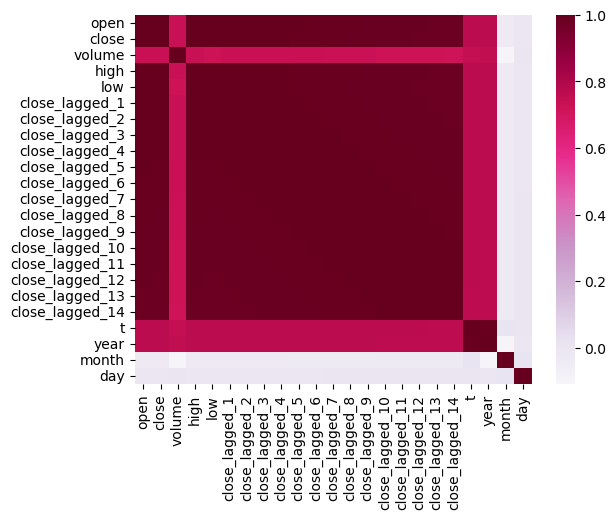

In [83]:
sns.heatmap(X.corr(), cmap=p)

In [84]:
def lin_model(X_train, X_valid, y_train, y_valid, pred_vars:list):
    """Fit a linear model to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple(float, RegressionResultsWrapper): out of sample r2 score and fit
    """
    # Train
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train)
    fit = model.fit()
    #fit.summary()
    # Test
    X_valid = sm.add_constant(X_valid)
    pred = fit.predict(X_valid)
    return error_measure(y_pred=pred, y_true=y_valid), fit

In [85]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]

X = btc_cut[pred_vars]
y = btc_cut.R7

X_train, X_valid, X_test, y_train, y_valid, y_test = data_split(X=X, y=y)

err, fit = lin_model(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid, pred_vars=pred_vars)
print(fit.summary())
print(f"MSE on Test Data: {error_measure(y_pred=fit.predict(sm.add_constant(X_test)), y_true = y_test)}")

                            OLS Regression Results                            
Dep. Variable:                     R7   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.965
Date:                Mon, 06 Mar 2023   Prob (F-statistic):             0.0518
Time:                        22:37:53   Log-Likelihood:                 1944.1
No. Observations:                2127   AIC:                            -3882.
Df Residuals:                    2124   BIC:                            -3865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.003      5.420      0.0

In [87]:
# Volume Price Lin Reg
y_pred = fit.predict(sm.add_constant(X_test))
e = error_measure(y_pred=y_pred, y_true=y_test)
print(f"Out of sample MSE: {e}")
print(f"Out of sample R2: {r2_score(y_pred=y_pred, y_true=y_test)}")

# In Sample
y_pred = fit.predict(sm.add_constant(X_train))
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.010310218911670114
Out of sample R2: -0.32744280918373425
In sample MSE: 0.009410898311524842
In sample R2: 0.002784202845538597


In [20]:
# Checking all available Models using the powerset of all predictors
def powerset(s):
    """Generator for all subsets of a given set
    Source:
        https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

    Args:
         (list): set to construct subsets of

    Yields:
        list: subset
    """
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]


high = 0  
pred_vars = ['open', 'close', 'volume', 'high', 'low', 'close_lagged_1',
             'close_lagged_2', 'close_lagged_3', 'close_lagged_4', 'close_lagged_5',
             'close_lagged_6', 'close_lagged_7', 't']#, 'year', 'month', 'day']

X = btc_cut[pred_vars]
y = btc_cut.R7

X_train, X_valid, X_test, y_train, y_valid, y_test = data_split(X=X, y=y)

best_set = []

pbar = tqdm(powerset(pred_vars), total=2**len(pred_vars))
for set in pbar:
    X_train_temp = X_train[set]
    X_valid_temp = X_valid[set]
    err, fit = lin_model(X_train=X_train_temp, X_valid=X_valid_temp, y_train=y_train, y_valid=y_valid, pred_vars=set)
    # # Select model based on out of sample r2
    # if r2 > high:
    #     high = r2
    #     best = fit
    # Select model based on in sample adj r2
    if fit.rsquared_adj > high:
        pbar.set_postfix({"Best Adj_R2:": fit.rsquared_adj})
        high = fit.rsquared_adj
        best = fit
        best_set = set
print(best.summary())
print(f"MSE on Test Data: {error_measure(y_pred=best.predict(sm.add_constant(X_test[best_set])), y_true = y_test)}")

100%|██████████| 8192/8192 [00:48<00:00, 167.58it/s, Best Adj_R2:=0.0529]

                            OLS Regression Results                            
Dep. Variable:                     R7   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     14.19
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           1.85e-22
Time:                        21:37:08   Log-Likelihood:                 2003.4
No. Observations:                2127   AIC:                            -3987.
Df Residuals:                    2117   BIC:                            -3930.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0219      0.005     -4.

## Random Forest

In [121]:
def random_forest(args:dict, X_train, y_train, X_valid, y_valid, pred_vars:list):
    """Fit a random forest to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple: out of sample r2 score and model
    """
    # Train
    rf = RandomForestRegressor(**args)
    model = rf.fit(X=X_train, y=y_train)
    # Test
    pred = rf.predict(X_valid)
    return error_measure(y_pred=pred, y_true=y_valid), model

In [22]:
# define args for Hyperparameter testing
args = [{"n_estimators": n, "min_samples_split": s, "max_features": m, "criterion": c} 
 for n in [100, 250, 500, 1000, 2000] 
 for s in [2, 3, 4] 
 for m in ["sqrt", "log2", 1.0]
 for c in ["squared_error", "absolute_error", "friedman_mse"]]

In [23]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]
best_e = np.Inf

# Get relevant predictors
X = btc_cut[pred_vars]
y = btc_cut.R7
# 80/20 split
X_train, X_valid, X_test, y_train, y_valid, y_test = data_split(X, y)

pbar = tqdm(args)
for arg in pbar:
    e, fit = random_forest(args=arg, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, pred_vars=pred_vars)
    pbar.set_postfix({"Current Args": arg, "Error": best_e})
    if e < best_e:
        best_e = e
        best_fit_rf_small = fit
        best_params_rf_small = arg
        pbar.set_postfix({"Current Args": arg, "Error": best_e})

100%|██████████| 135/135 [28:33<00:00, 12.69s/it, Current Args={'n_estimators': 2000, 'min_samples_split': 4, 'max_features': 1.0, 'criterion': 'friedman_mse'}, Error=0.0196]     


In [28]:
# Out of Sample
y_pred = best_fit_rf_small.predict(X_test)
e = error_measure(y_pred=y_pred, y_true=y_test)
print(f"Out of sample MSE: {e}")
print(f"Out of sample R2: {r2_score(y_pred=y_pred, y_true=y_test)}")

# In Sample
y_pred = best_fit_rf_small.predict(X_train)
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.028055844040742975
Out of sample R2: -2.612195700841022
In sample MSE: 0.001667355382773977
In sample R2: 0.8233204661093267


In [25]:
# Save best model so no retraining needes
dump(best_fit_rf_small, "best_fit_rf_small.joblib")

['best_fit_rf_small.joblib']

In [29]:
# Load model
best_fit_rf_small = load("best_fit_rf_small.joblib")

In [44]:
# Model with lagged prices
pred_vars = btc_cut.columns.drop(["date", "R7"])

# Get relevant predictors
pred_vars = [col for col in btc.columns if col not in ["date", "R7"]]
X = btc_cut[pred_vars]
y = btc_cut.R7
# 80/20 split
X_train, X_valid, X_test, y_train, y_valid, y_test = data_split(X, y)

In [127]:
pbar = tqdm(args)
best_e = np.Inf
for arg in pbar:
    e, fit = random_forest(args=arg, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, pred_vars=pred_vars)
    pbar.set_postfix({"Current Args": arg, "Error": best_e})
    if e < best_e:
        best_e = e
        best_fit_rf_large = fit
        best_params_rf_large = arg
        pbar.set_postfix({"Current Args": arg, "Error": best_e})


y_pred = best_fit_rf_large.predict(X_test)
e = error_measure(y_pred=y_pred, y_true=y_test)
print(f"Out of sample MSE: {e}")

100%|██████████| 135/135 [4:10:44<00:00, 111.44s/it, Current Args={'n_estimators': 2000, 'min_samples_split': 4, 'max_features': 1.0, 'criterion': 'friedman_mse'}, Error=0.0124]       

Out of sample MSE: 0.01006468537864594


In [129]:
# Save Model
dump(best_fit_rf_large, "best_fit_rf_large.joblib")

['best_fit_rf_large.joblib']

In [34]:
# Load Model
best_fit_rf_large = load("best_fit_rf_large.joblib")

In [45]:
# Out of Sample
y_pred = best_fit_rf_large.predict(X_test)
e = error_measure(y_pred=y_pred, y_true=y_test)
print(f"Out of sample MSE: {e}")
print(f"Out of sample R2: {r2_score(y_pred=y_pred, y_true=y_test)}")

# In Sample
y_pred = best_fit_rf_large.predict(X_train)
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.01006468537864594
Out of sample R2: -0.2958303162174116
In sample MSE: 0.0005879013800771984
In sample R2: 0.9377036576132232


[Text(0.5, 1.0, 'Variable Importance')]

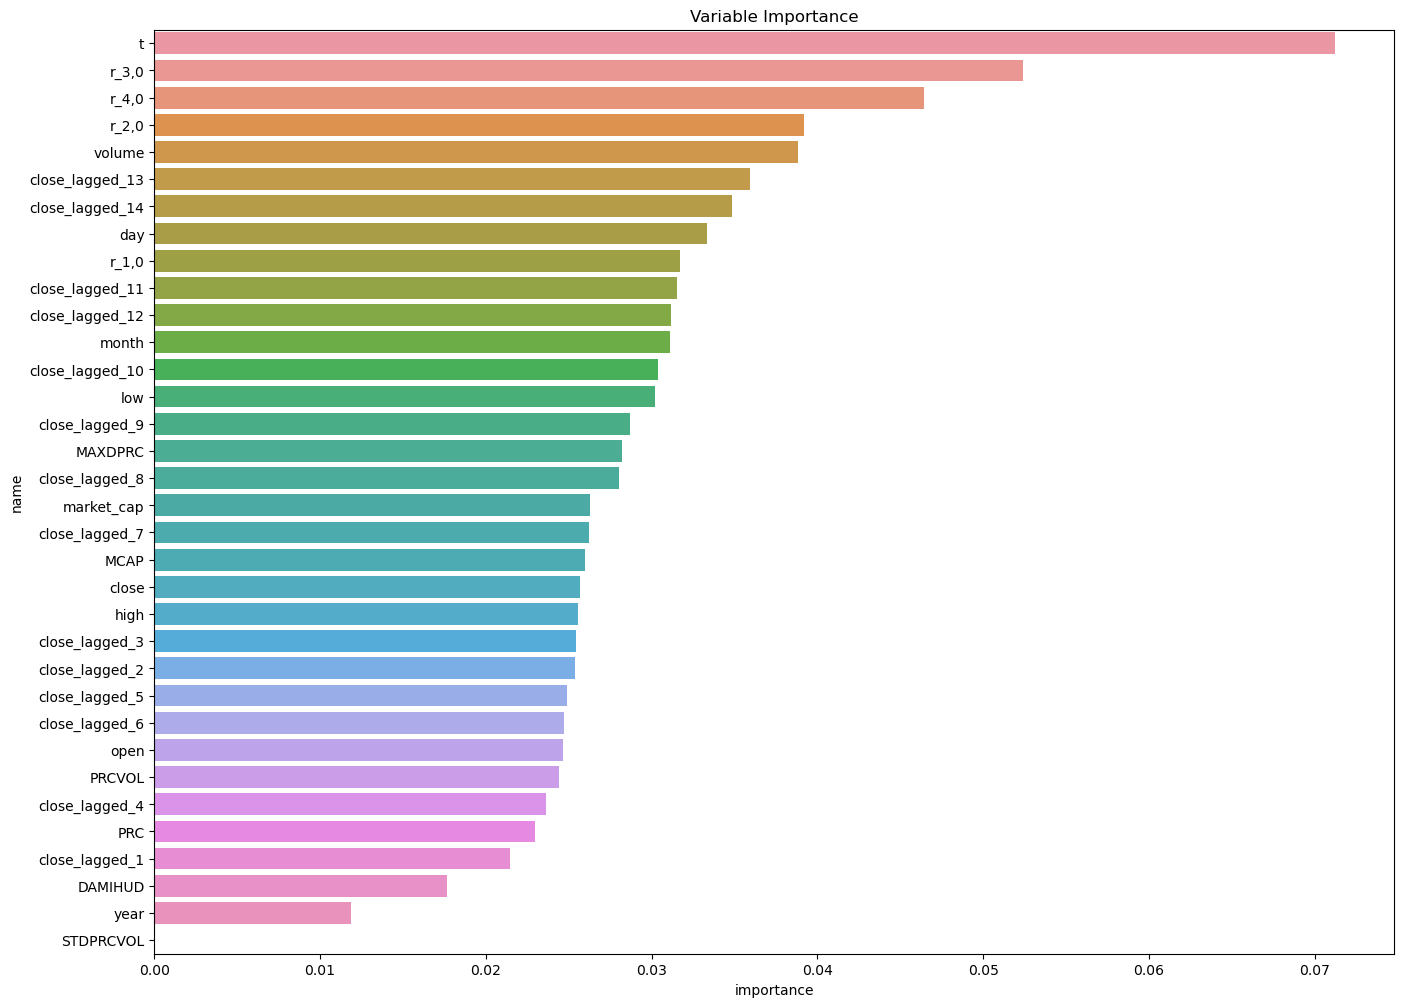

In [130]:
pred_vars = best_fit_rf_large.feature_names_in_
imp = pd.DataFrame({"importance":best_fit_rf_large.feature_importances_, "name": pred_vars})
imp = imp.sort_values(by=["importance"], ascending=False)

fig, ax = plt.subplots(figsize=(16, 12), nrows=1, ncols=1)
sns.barplot(x=imp.importance,y=imp.name, ax=ax).set(title='Variable Importance')

## SVM

In [93]:
def data_split2(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)
    return X_train, X_test, y_train, y_test

In [102]:
def svm(pred_vars:list):
    """Fit a svm to the btc prices given a list of regressors

    Args:
        pred_vars (list[string]): names of the regessors

    Returns:
        tuple: out of sample r2 score and model
    """
    # Get relevant predictors
    X = btc_cut[pred_vars]
    y = btc_cut.R7
    # Split data
    X_train, X_test, y_train, y_test = data_split2(X, y)
    # Train
    svm = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    #svm = SVR(kernel = 'rbf')
    model = svm.fit(X_train, y_train)
    # Test
    pred = svm.predict(X_test)
    return error_measure(y_pred=pred, y_true=y_test.values), model, X_train, X_test, y_train, y_test

In [103]:
# Test small model with only close and volume
pred_vars = ["close", "volume"]
err, fit, X_train, X_test, y_train, y_test = svm(pred_vars=pred_vars)

y_pred = fit.predict(X_test)
print(f"Out of sample MSE: {err}")
print(f"Out of sample R2: {r2_score(y_pred=y_pred, y_true=y_test)}")

# In Sample
y_pred = fit.predict(X_train)
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.010575043578368738
Out of sample R2: -0.21409478028794005
In sample MSE: 0.008811364367308314
In sample R2: 0.06631317747816012


# Task 5
Divide factors’ data into training, validation, and testing samples and use the machine learning
techniques from the last step to evaluate the performance of these factors for return prediction.

In [119]:
pred_vars = [col for col in btc.columns if col not in ["date", "R7"]]
X_train, X_test, y_train, y_test = data_split2(btc_cut[pred_vars], btc_cut.R7)

## Random Forest

In [123]:
params = best_fit_rf_large.get_params()

e, fit = random_forest(params, X_train=X_train, X_valid=X_test, y_train=y_train, y_valid=y_test, pred_vars=[])
print(f"Out of sample MSE: {e}")
print(f"Out of sample R2: {r2_score(y_pred=fit.predict(X_test), y_true=y_test)}")

# In Sample
y_pred = fit.predict(X_train)
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.011219137492268359
Out of sample R2: -0.28804162060927196
In sample MSE: 0.0005879013800771984
In sample R2: 0.9377036576132232


## SVM

In [125]:
e, fit, X_train, X_test, y_train, y_test = svm(pred_vars=pred_vars)
print(f"Out of sample MSE: {e}")
print(f"Out of sample R2: {r2_score(y_pred=fit.predict(X_test), y_true=y_test)}")

# In Sample
y_pred = fit.predict(X_train)
print(f"In sample MSE: {error_measure(y_pred=y_pred, y_true=y_train)}")
print(f"In sample R2: {r2_score(y_pred=y_pred, y_true=y_train)}")

Out of sample MSE: 0.013789644191503862
Out of sample R2: -0.5831551814290765
In sample MSE: 0.006333957480152685
In sample R2: 0.3288289546197962


# Task 7
Consider an initial investment of 100,000€ and the following trading strategy: First, a negative
development forecast of the Bitcoin price is interpreted as a sell signal. Accordingly, a forecast
of increasing Bitcoin prices indicates a reasonable moment for buying additional Bitcoins if the
overall budget allows the additional investment. Second, at the beginning of the trading period,
the complete budget is invested in Bitcoins with a price of p_0. Third, if the entire budget is invested,
the strategy does not imply actions during a subsequent predicted increase for the Bitcoin price.
Fourth, if the forecasting model predicts decreasing prices, Bitcoins are sold at the current price p_t.
Fifth, when Bitcoin prices are predicted to rise again, the strategy suggests investing the complete
available budget on Bitcoins at the current price p_t+k. In this setting, we consider Bitcoin trading
costs to be negligible.
Use out-of-sample return predictions between 31.05.21-31.05.2022 from steps four and five for trading. Compare your results with a buy-and-hold strategy (i.e., Bitcoin is purchased at time 0 for a
price of p0 and sold at the end of the period t = 1, ..., T for a price of p_T ).


In [131]:
# Training Data
Train = btc_cut.loc[btc_cut.date <= datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
Test = btc_cut.loc[btc_cut.date > datetime(2021, 5, 1,0,0,0,0, pytz.UTC),]
# ! different Time Zones
Test = Test.loc[Test.date <= datetime(2022, 5, 2,0,0,0,0, pytz.UTC),]

In [171]:
def RF_regression(pred_vars:list):
    X_train = Train[pred_vars]
    y_train = Train["R7"]
    rf = RandomForestRegressor(n_estimators = 2000, random_state = 1)
    model = rf.fit(X=X_train, y=y_train)
    return model

def RF_classification(pred_vars:list):
    X_train = Train[pred_vars]
    y_train = Train["R7"].apply(lambda x: x > 0)
    rf = RandomForestClassifier(n_estimators = 2000, random_state = 1)
    model = rf.fit(X=X_train, y=y_train)
    return model

def SVM_classification(pred_vars:list):
    X_train = Train[pred_vars]
    y_train = Train["R7"].apply(lambda x: x > 0)
    # Parameters
    svm = SVC(kernel="rbf")
    model = svm.fit(X=X_train, y=y_train)
    return model

In [172]:
# Pred Vars
pred_vars = [col for col in Train.columns if col not in ["date", "R7"]]

# Train random forrest regressor
rf_reg = RF_regression(pred_vars=pred_vars)

# Train random forrest classifier
rf_class = RF_classification(pred_vars=pred_vars)

# Train SVM
svm = SVM_classification(pred_vars=pred_vars)

In [173]:
def calc_ts(signals:list, name:str, verbose:bool=True):
    # Starting Capital
    m = 10_000
    coins = 0
    capital_ts = list()
    
    for i, signal in enumerate(signals):
        price = Test.iloc[i].close
        if signal and m:
            # Buy
            coins = m/price
            m = 0
            if verbose: print(f"[INFO] {name} Bought {coins} BTC at {price}")
        elif not signal and coins:
            # Sell
            m = coins * price
            if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
            coins = 0
        # Append current net worth
        capital_ts.append(m + coins*price)
    # Sell after last period
    if coins:
        price = Test.iloc[i].close
        m = coins * price
        if verbose: print(f"[INFO] {name} Sold {coins} BTC at {price}")
        coins = 0
    print(f"[INFO] {name}: Total Capital {m}")
    plt.plot(capital_ts, label=name)
    return capital_ts, m

[INFO] rf_class: Total Capital 7849.858644964023
[INFO] rf_reg: Total Capital 6181.274531406644
[INFO] svm_class: Total Capital 7821.32350350403
[INFO] buy_and_hold: Total Capital 6521.899862259137
[INFO] random: Total Capital 5764.798359477361


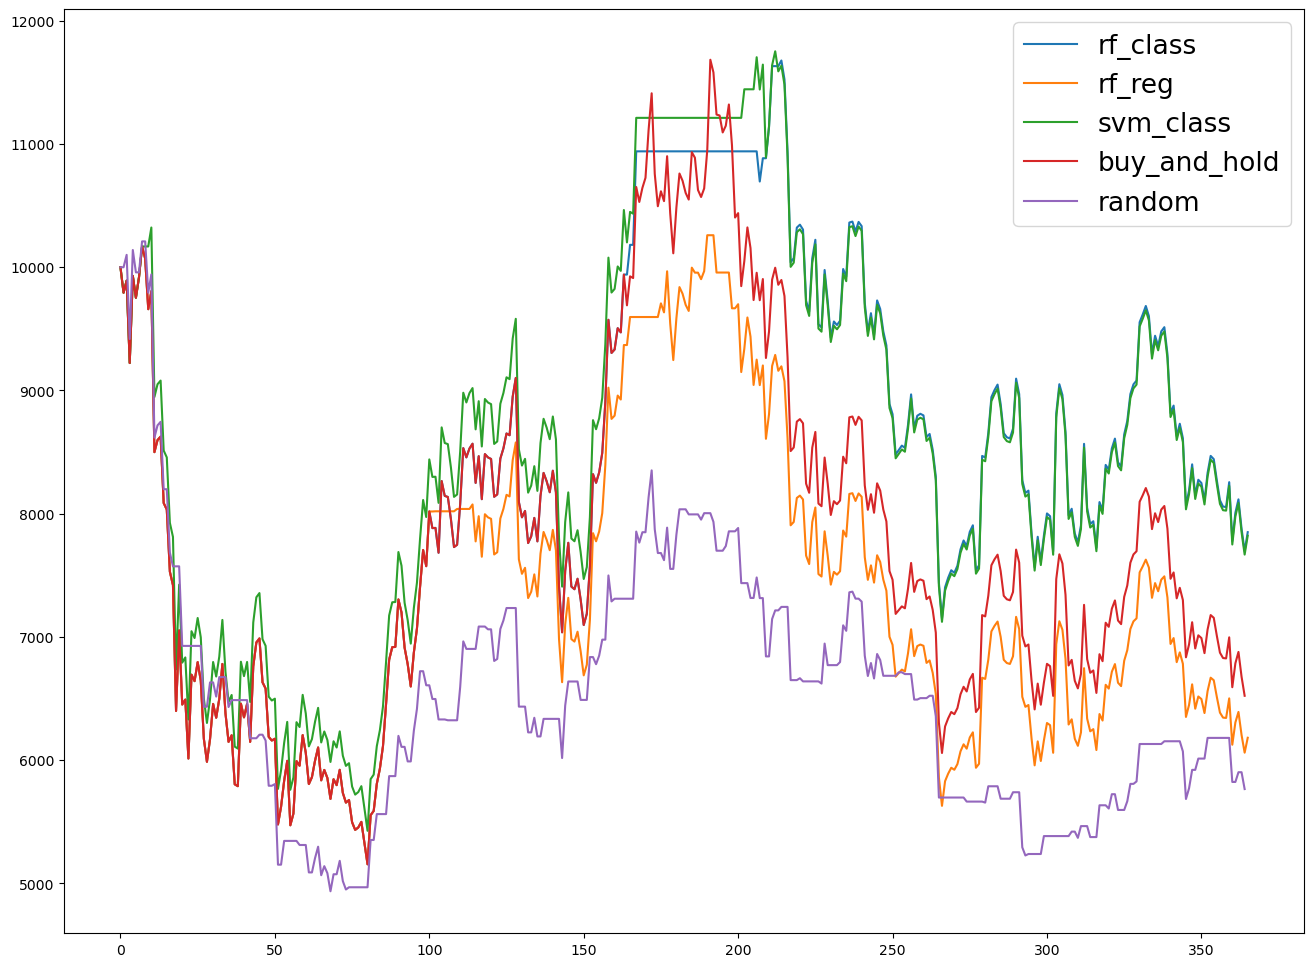

In [174]:
fig, ax = plt.subplots(figsize=(16, 12), nrows=1, ncols=1)
# No retraining after each timestep has passed
rf_class_signals = rf_class.predict(Test[pred_vars])
calc_ts(signals=rf_class_signals, name="rf_class", verbose=False)

rf_reg_signals = [signal >= 0 for signal in rf_reg.predict(Test[pred_vars])]
calc_ts(signals=rf_reg_signals, name="rf_reg", verbose=False)

svm_signals = svm.predict(Test[pred_vars])
calc_ts(signals=svm_signals, name="svm_class", verbose=False)

buy_and_hold_signals = [True]*365
calc_ts(signals=buy_and_hold_signals, name="buy_and_hold", verbose=False)

random_signals = [signal >=0 for signal in np.random.randn(365)]
calc_ts(signals=random_signals, name="random", verbose=False)

plt.legend(prop={'size': 19})